<a href="https://colab.research.google.com/github/chimaOkwuokei/ISEND-PAU/blob/main/RegNet_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torchinfo

In [4]:
#imports
import torch
import torchvision
import os
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
from matplotlib import pyplot as plt
from PIL import Image

In [5]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
# 1. Get pretrained weights for RegNet_Y_128GF
pretrained_regnet_weights = torchvision.models.regnet_y_16gf(weights=torchvision.models.RegNet_Y_16GF_Weights.DEFAULT)

# 2. Setup a RegNet model instance with pretrained weights
pretrained_regnet = torchvision.models.regnet_y_16gf(weights=pretrained_regnet_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_regnet.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

# Update the classifier head
pretrained_regnet.fc = nn.Linear(in_features=pretrained_regnet.fc.in_features, out_features=len(class_names)).to(device)

# 5. Print a summary using torchinfo
summary(model=pretrained_regnet,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Downloading: "https://download.pytorch.org/models/regnet_y_16gf-3e4a00f9.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_16gf-3e4a00f9.pth
100%|██████████| 319M/319M [00:26<00:00, 12.8MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_16GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_16GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_16gf-9e6ed7dd.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_16gf-9e6ed7dd.pth
100%|██████████| 319M/319M [00:19<00:00, 16.9MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [32, 3, 224, 224]    [32, 6]              --                   Partial
├─SimpleStemIN (stem)                                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    └─Conv2d (0)                                            [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNorm2d (1)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    └─ReLU (2)                                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (trunk_output)                                  [32, 32, 112, 112]   [32, 3024, 7, 7]     --                   False
│    └─AnyStage (block1)                                     [32, 32, 112, 112]   [32, 

In [10]:
!unzip -q /content/NEU.zip

In [12]:
# Setup directory paths to train and test images
train_dir = '/content/NEU/train'
test_dir = '/content/NEU/test'

In [14]:
# The RegNet model from torchvision doesn't have a method like transforms() associated with its weights. This method is available for some models (like ViT) but not for others.
# Define the image transformations

regnet_transforms = transforms.Compose([
    transforms.Resize(256),  # Resize to 256x256 pixels
    transforms.CenterCrop(224),  # Center crop to 224x224 pixels (standard for most models)
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Verify the transformations
print(regnet_transforms)

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [15]:
# Function to create dataloaders
def create_dataloaders(train_dir, test_dir, transform, batch_size, num_workers=os.cpu_count()):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_dataloader, test_dataloader, train_data.classes

In [16]:
# Setup dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir, test_dir, regnet_transforms, batch_size=32)



In [17]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_regnet.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()


In [18]:
!git clone https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer


Cloning into 'Image-Classification-Using-Vision-transformer'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 43 (delta 12), reused 8 (delta 8), pack-reused 29 (from 1)
Receiving objects: 100% (43/43), 862.14 KiB | 29.73 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [20]:
from going_modular.going_modular import engine
import time
# Start the timer
start_time = time.time()

pretrained_regnet_results = engine.train(model=pretrained_regnet,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

# Stop the timer
end_time = time.time()

# Calculate the total training time in minutes
total_time_minutes = (end_time - start_time) / 60

# Print the total training time
print(f"Training completed in {total_time_minutes:.2f} minutes.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2639 | train_acc: 0.9487 | test_loss: 0.0811 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.1190 | train_acc: 0.9834 | test_loss: 0.0500 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0892 | train_acc: 0.9848 | test_loss: 0.0224 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0642 | train_acc: 0.9902 | test_loss: 0.0232 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0448 | train_acc: 0.9958 | test_loss: 0.0123 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0451 | train_acc: 0.9940 | test_loss: 0.0148 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0348 | train_acc: 0.9946 | test_loss: 0.0112 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0326 | train_acc: 0.9964 | test_loss: 0.0095 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0354 | train_acc: 0.9926 | test_loss: 0.0119 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0318 | train_acc: 0.9940 | test_loss: 0.0056 | test_acc: 1.0000
Training completed in 3.30 minutes.


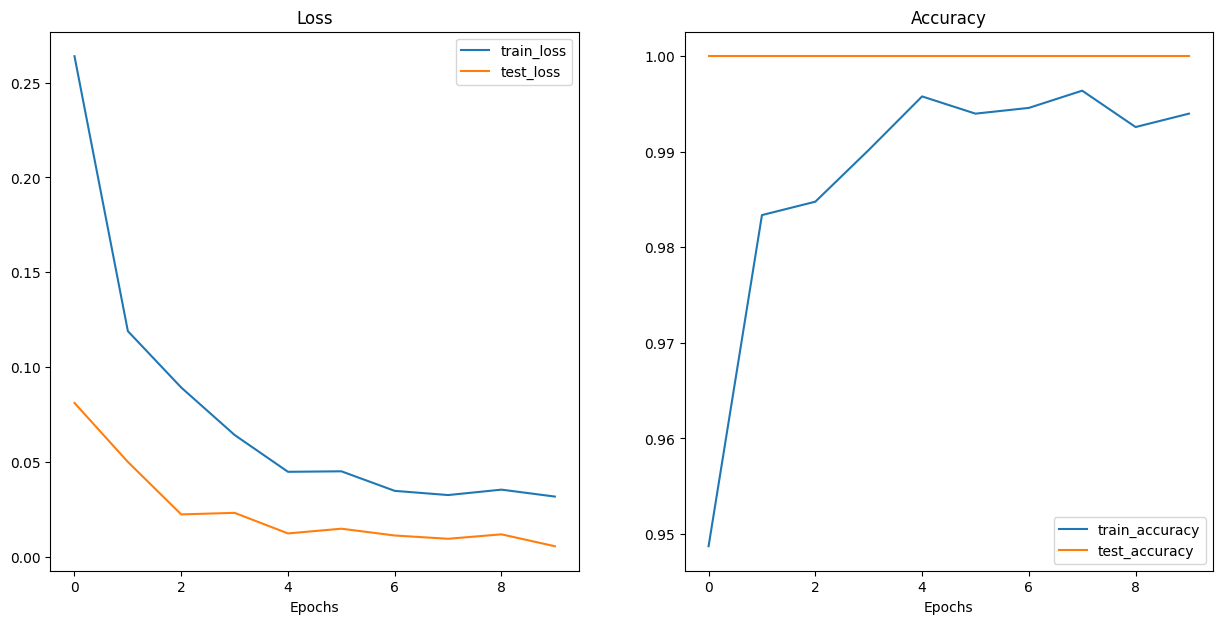

In [21]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_regnet_results)

Image is grayscale, converting to RGB...


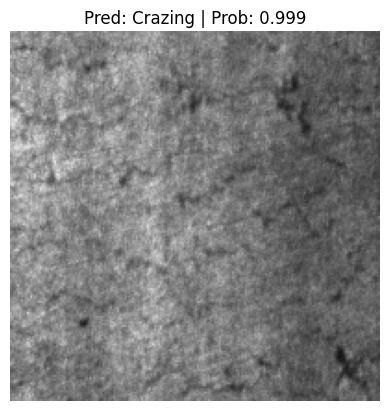

In [41]:
import requests
from PIL import Image
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup original custom image path
custom_image_path = "Cr_119.bmp"

# Load the image
image = Image.open(custom_image_path)

# Convert to RGB if it's not already in RGB mode
if image.mode != "RGB":
    print("Image is grayscale, converting to RGB...")
    image = image.convert("RGB")

# Save the RGB image to a new file
rgb_image_path = "rgb.bmp"
image.save(rgb_image_path)

# Now use the new RGB image path for prediction
pred_and_plot_image(model=pretrained_regnet,
                    image_path=rgb_image_path,
                    class_names=class_names)
